#Cafiar-10 dataset

In [ ]:
import torch
import torchvision
from torch import optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
trainset = datasets.CIFAR10('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))

100%|██████████| 170498071/170498071 [00:04<00:00, 42515638.87it/s]


Extracting cifar/cifar-10-python.tar.gz to cifar


In [ ]:
trainset = DataLoader(trainset, batch_size=32, shuffle=True)

In [ ]:
next(iter(trainset))
x, label = next(iter(trainset))
x.shape, label.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [ ]:
testset = datasets.CIFAR10('cifar', False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))

In [ ]:
testset = DataLoader(testset, batch_size=32, shuffle=True)

In [ ]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=3, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=3, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=3, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


def test():
    net = ResNet18(img_channels=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())

In [ ]:
device = torch.device('cpu')
model = ResNet18(img_channels=3, num_classes=10).to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
loss_li = []
acc_li = []
for epoch in range(50):
    for idx, (x, label) in enumerate(trainset):
        x, label = x.to(device), label.to(device)
#         print(x.shape, label.shape)
        logits = model(x) # b [b, 10]
        loss = criterion(logits, label) # label: [b]
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        tot_corr = 0
        tot_num = 0
        
        for x, label in testset:
            x, label = x.to(device), label.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            
            tot_corr += torch.eq(pred, label).float().sum().item() # using item() to convert tensor to number
            tot_num += x.size(0)
        acc = tot_corr / tot_num
        
    loss_li.append(loss.item())
    acc_li.append(acc)
    
    print('epoch: {}, loss: {}, acc: {}'.format(epoch, loss, acc))

epoch: 0, loss: 1.0494736433029175, acc: 0.5252
epoch: 1, loss: 0.904350757598877, acc: 0.6401
epoch: 2, loss: 0.8483237028121948, acc: 0.6541
epoch: 3, loss: 1.527646780014038, acc: 0.669
epoch: 4, loss: 0.6305622458457947, acc: 0.6886
epoch: 5, loss: 0.9744113087654114, acc: 0.7042
epoch: 6, loss: 0.5962002873420715, acc: 0.7143
epoch: 7, loss: 0.7081887125968933, acc: 0.6996
epoch: 8, loss: 0.8310356140136719, acc: 0.721
epoch: 9, loss: 0.12180649489164352, acc: 0.7233
epoch: 10, loss: 0.3224905729293823, acc: 0.7079
epoch: 11, loss: 0.44487640261650085, acc: 0.7214
epoch: 12, loss: 0.5014680624008179, acc: 0.7101
epoch: 13, loss: 0.15519312024116516, acc: 0.7273
epoch: 14, loss: 0.36994993686676025, acc: 0.7161
epoch: 15, loss: 0.1579764038324356, acc: 0.7278
epoch: 16, loss: 0.03716859221458435, acc: 0.7234
epoch: 17, loss: 0.11839747428894043, acc: 0.717
epoch: 18, loss: 0.42049720883369446, acc: 0.7153
epoch: 19, loss: 0.11026928573846817, acc: 0.7077
epoch: 21, loss: 0.17532595

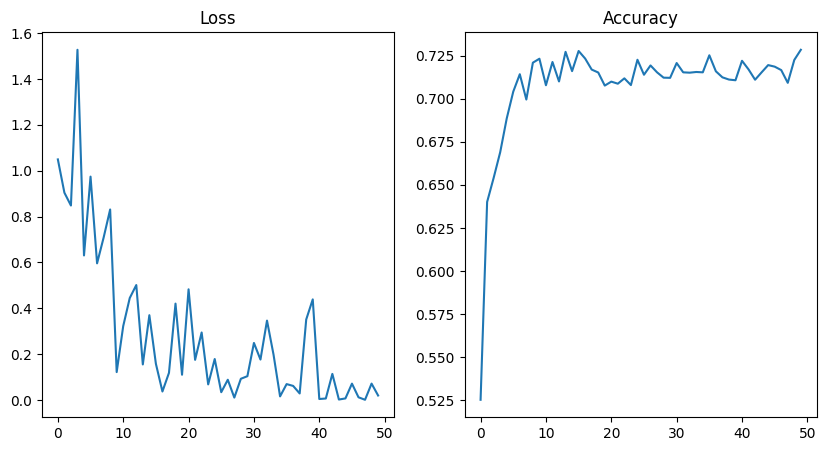

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(loss_li)
ax[0].set_title('Loss')
ax[1].plot(acc_li)
ax[1].set_title('Accuracy')
plt.show()

In [ ]:
print("The state dict keys: \n\n", model.state_dict().keys())

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.conv1.bias', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.conv2.bias', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.conv3.bias', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.identity_downsample.0.weight', 'layer1.0.identity_downsample.0.bias', 'layer1.0.identity_downsample.1.weight', 'layer1.0.identity_downsample.1.bias', 'layer1.0.identity_downsample.1.running_mean', 'layer1.0.identity_downsample.1.running_var', 'layer1.0.identity_downsample.1.nu

In [ ]:
checkpoint = {'model': ResNet18(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'pytorch.h5')

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model